
# Data Engineering Capstone Project: 
## i-94 Immigration Analtyics 


##### PROJECT SUMMARY: 
The objective of this project was to create an Elt pipeline for I94 immigration, global land temperatures and happiness and Human development index datsets to form an analytics database on immigration events. 

A use case for this analytics database is to find immigration patterns for the US immigration department.

For example, they could try to find answears to questions such as:

- Which are the countries with better Human development index than United states that people imigrate from in april 2016?

- Do people from countries with warmer or cold climate immigrate to the US in large numbers?

- Do people come from developed countries?

- Does Freedom and Human development imply in the number of people coming in to the us?

In [1]:
import pandas as pd
import configparser
from datetime import datetime
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import from_unixtime, to_timestamp
from pyspark.sql.functions import *
from pyspark.sql.functions import col, hour, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
import datetime as dt
from datetime import timedelta, datetime
from pyspark.sql.functions import monotonically_increasing_id

In [2]:
# Do all imports and installs here
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.facecolor'] = 'b'

output_data = "s3://capstoneprojectsiva/"

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

## DATASETS

### 1) Immigration dataset

This data comes from the US National Tourism and Trade Office. This dataset forms the core of the data warehouse and the customer repository has a years worth of data for the year 2016 and the dataset is divided by month. For this project the data is in a folder located at ../../data/18-83510-I94-Data-2016/. Each months data is stored in an SAS binary database storage format sas7bdat. For this project we are work with data for the month of April. 

"However, the data extraction, transformation and loading utility functions have been designed to work with any month's worth of data."


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [4]:
drop_columns = ["visapost", "occup", "entdepu", "insnum","count", "entdepa", "entdepd", "matflag", "dtaddto", "biryear", "admnum","fltno", "airline"]
df_spark = df_spark.drop(*drop_columns)

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [5]:
#spark_Pandas=df_spark.select([count(when(col(c).isNull()|isnan(c), c)).alias(c) for c in df_spark.columns]).toPandas().transpose()
spark_df = df_spark.select([count(when(isnan(c)|col(c).isNull(), c)).alias(c) for c in df_spark.columns]).toPandas().transpose()

In [6]:
spark_df

,0
cicid,0
i94yr,0
i94mon,0
i94cit,0
i94res,0
i94port,0
arrdate,0
i94mode,239
i94addr,152592
depdate,142457


#### Global Temperature dataset: The World Temperature dataset comes from Kaggle and represents global land temperatures by city.

In [7]:
# Temperature Data
temp_df= spark.read.csv("../../data2/GlobalLandTemperaturesByCity.csv",header=True, inferSchema=True)

In [8]:
temp_df = temp_df.dropna(subset=['AverageTemperature'])
# drop duplicate rows
temp_df = temp_df.drop_duplicates(subset=['dt', 'City', 'Country'])
#temp_df.show(10)

### 3) Happiness data & Human Development data: 
The World Happiness Report is a well-known source of cross-country data and research on self-reported life satisfaction. The table here shows, country by country, the ‘happiness scores’ extracted this report

In [9]:
# 3) Happiness and Development Dataset

# Temperature Data
Happiness_Develepment_data= spark.read.csv("Lookup/happiness_and_development.csv",header=True, inferSchema=True)

In [10]:
Happiness_Develepment_data.show(3)

+-----------+--------------+-----------------------+----------------------------+-------------------------+---------------------+
|    Country|Social support|Healthy life expectancy|Freedom to make life choices|Perceptions of corruption|HumanDevelopmentIndex|
+-----------+--------------+-----------------------+----------------------------+-------------------------+---------------------+
|    finland|         0.954|                   72.0|                       0.949|                    0.186|                 0.92|
|    denmark|         0.954|                   72.7|                       0.946|                    0.179|                0.929|
|switzerland|         0.942|                   74.4|                       0.919|                    0.292|                0.944|
+-----------+--------------+-----------------------+----------------------------+-------------------------+---------------------+
only showing top 3 rows



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

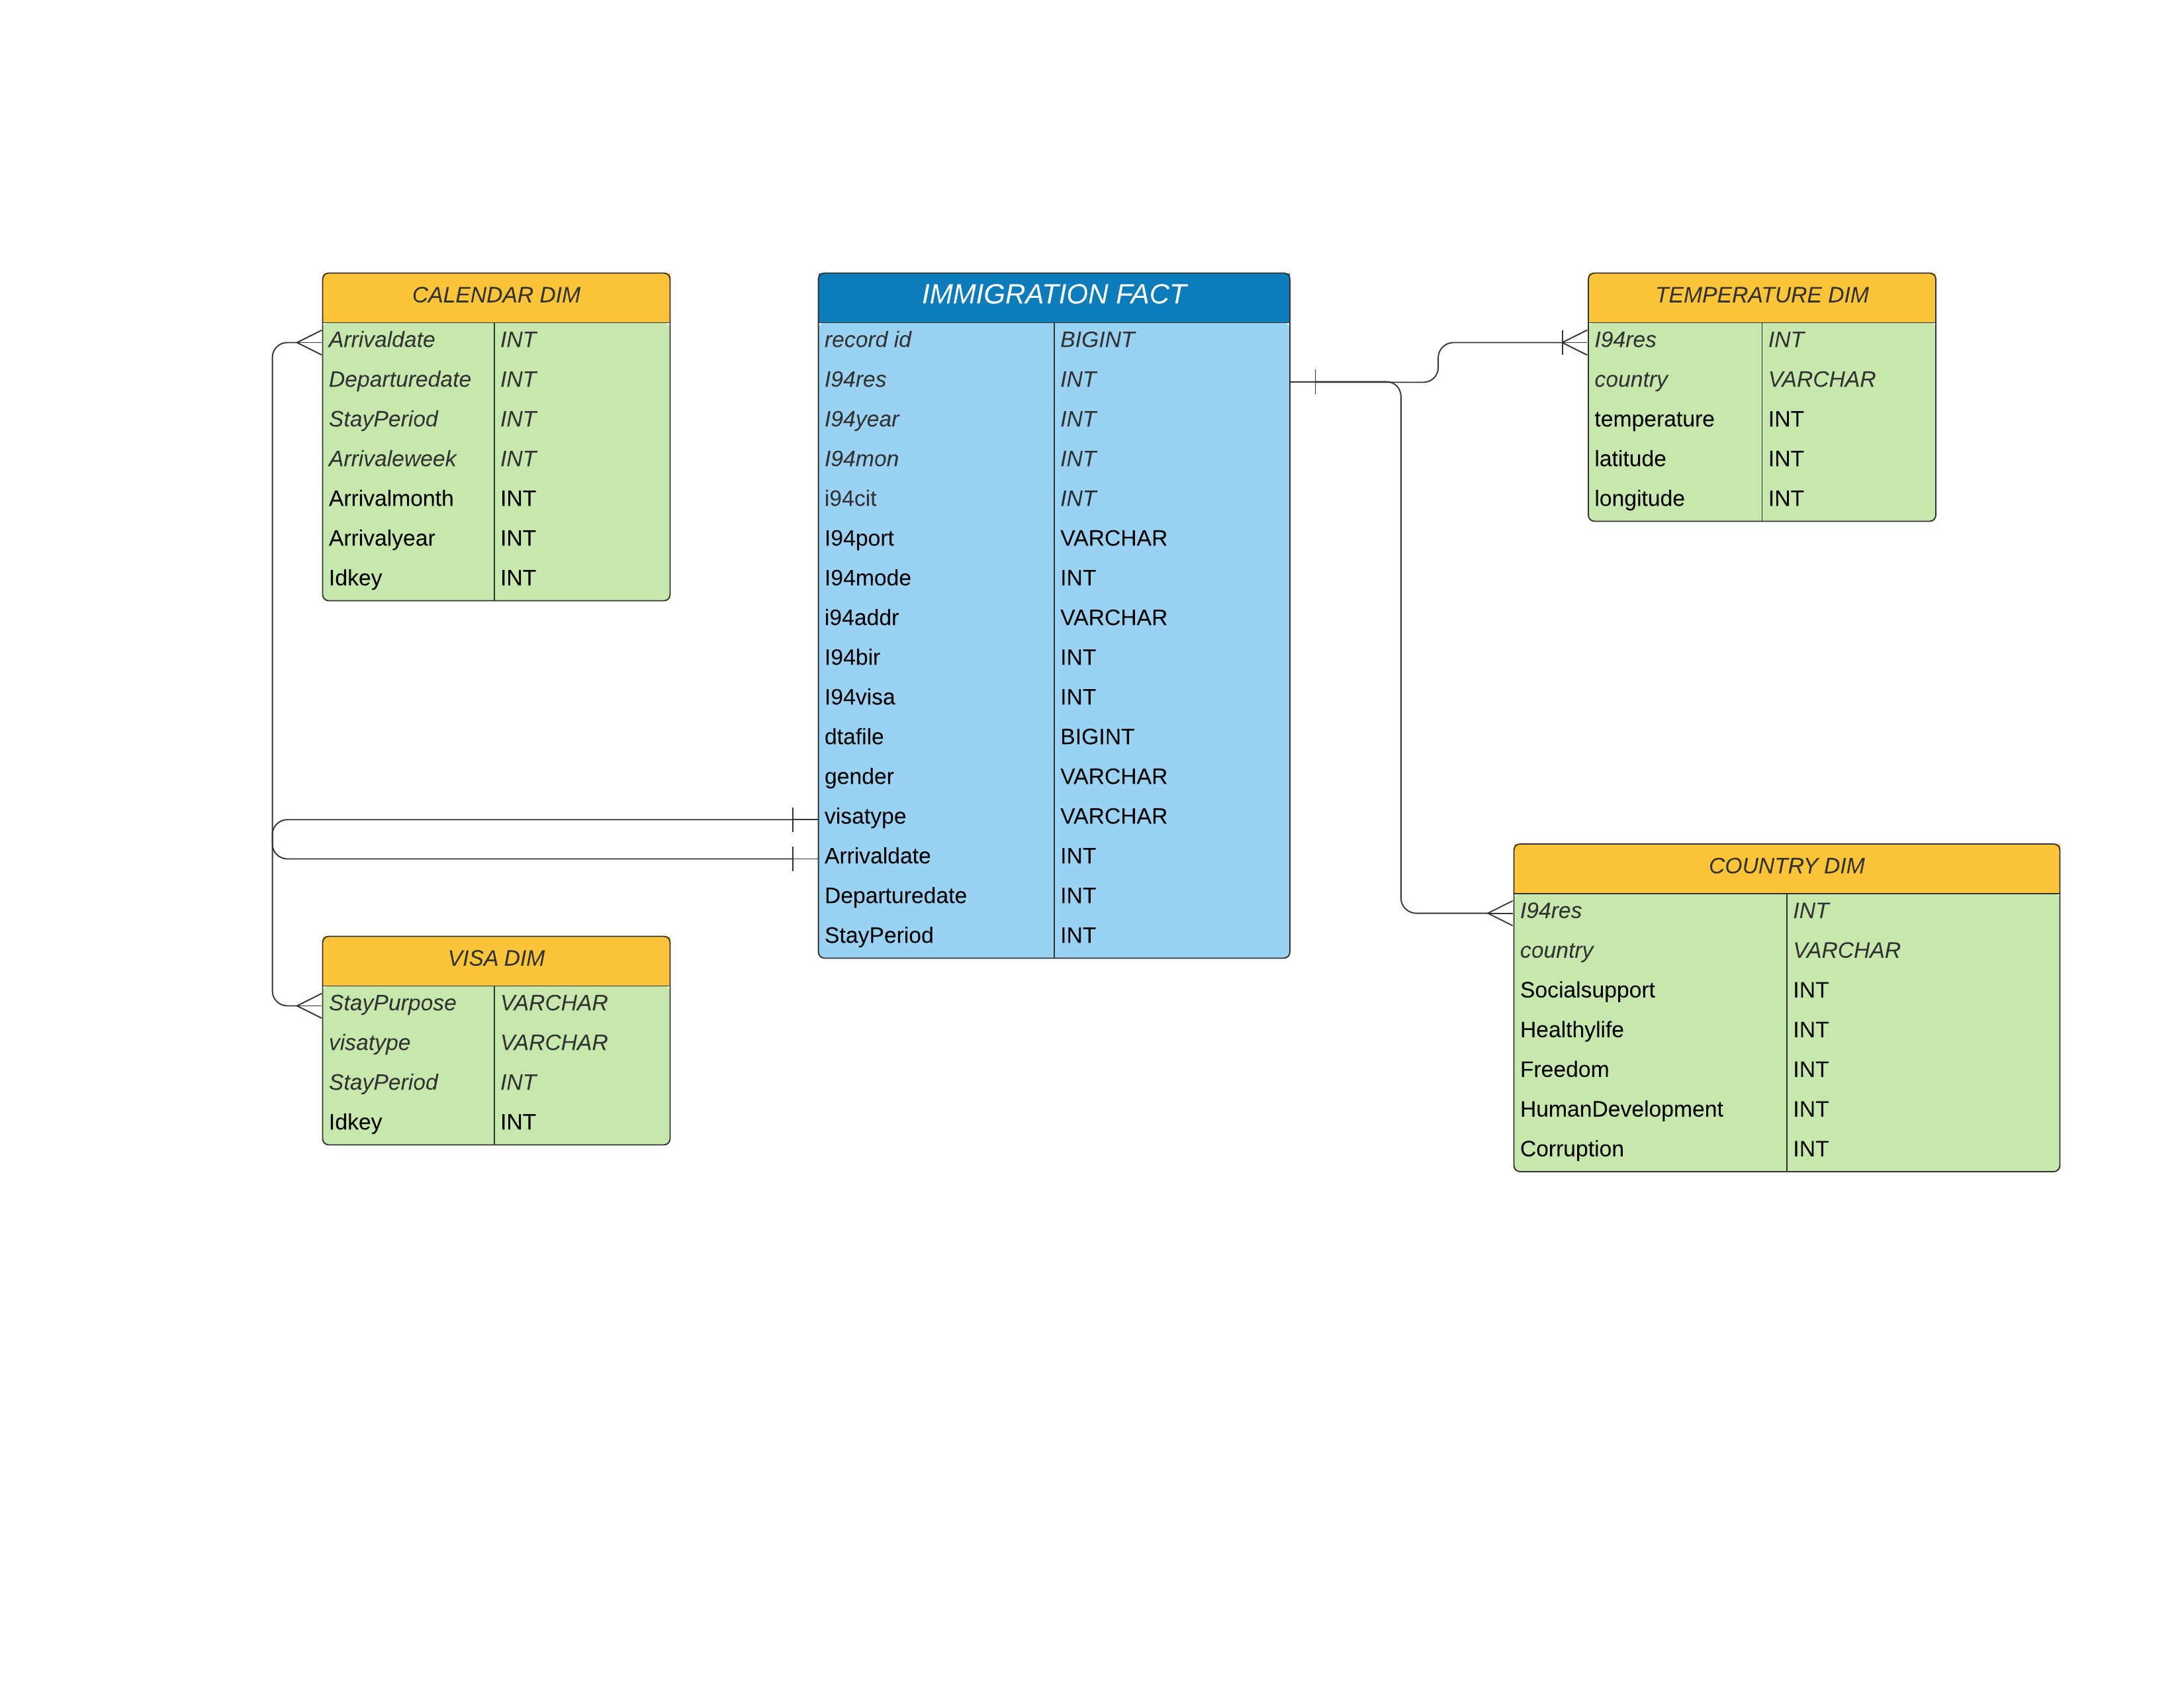

In [11]:
from IPython import display
display.Image("images/data_model.png")

* The country dimension table is made up of data from the happiness and Human development tables. The combination of these two datasets.

* The visa type dimension table comes from the immigration datasets and links to the immigaration via , the stay period and the visa_type.

* The immigration fact table is the heart of the data model. This table's data comes from the immigration data sets and contains keys that links to the dimension tables. The data dictionary of the immigration dataset contains detailed information on the data that makes up the fact table.

* The Temperature dimesion table is made of temperature of each countries from where immigrants are coming from.

* The Calendar table provide the analytics team with the arrival date, the departure date, stay period, year, month and week day.

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model. The pipeline steps are as follows:

- Loading the datasets
- Cleaning the I94 Immigration data to create Spark dataframe for each month
- Creat immigration fact table
- Create visa_type dimension table
- Create calendar dimension table
- Create Temperature dimesion table
- Create Country dimension table
- Implement Data Quality Checks

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [12]:
def clean_spark_immigration_data(df):
    """Clean immigration dataframe
    :param df: spark dataframe with monthly immigration data
    :return: clean dataframe
    """
    total_records_count = df.count()
    print(f'Total records in dataframe: {total_records_count:,}')
    
    # EDA has shown these columns to exhibit over 90% missing values, and hence we drop them
    drop_columns = ["visapost", "occup", "entdepu", "insnum","count", "entdepa", "entdepd", "matflag", "dtaddto", "biryear", "admnum","fltno", "airline"]

    df = df.drop(*drop_columns)    
    # drop rows where all elements are missing
    df = df.dropna(how='all')

    return df

In [13]:
df=clean_spark_immigration_data(df_spark)

Total records in dataframe: 3,096,313


In [14]:
def create_immigration_fact_table(spark, df):
    """
     This Function Creates visa dimension table
    
    :param df: spark dataframe of the immigration data
    :output: path to write visa dimension table
    :return: Visa dataframe
    """
    
    @udf()
    def date_diff(date1, date2):
    #Calculates the difference in days between two dates
    
        if date2 is None:
            return None
        else:
            a = datetime.strptime(date1, date_format)
            b = datetime.strptime(date2, date_format)
            delta = b - a
            return delta.days

    date_format = "%Y-%m-%d"
    
    #User defined functions using Spark udf wrapper function to convert SAS dates into string dates in the format YYYY-MM-DD
    convert_sas_udf = udf(lambda x: x if x is None else (timedelta(days=x) + datetime(1960, 1, 1)).strftime(date_format))
    
    df = df.withColumn("Arrival_date", convert_sas_udf(col("arrdate"))) 
    df = df.withColumn("Departure_date", convert_sas_udf(col("depdate")))
    df = df.withColumn('Stay_period', date_diff(col('Arrival_date'), col('Departure_date')))
    df = df.withColumnRenamed('cicid','record_id')
    df = df.drop("arrdate","depdate")
    df.show(3)
    
    #df.write.parquet("s3://capstoneprojectsiva/", mode="overwrite")
    
    return df

In [15]:
fact_df=create_immigration_fact_table(spark, df)

+---------+------+------+------+------+-------+-------+-------+------+-------+--------+------+--------+------------+--------------+-----------+
|record_id| i94yr|i94mon|i94cit|i94res|i94port|i94mode|i94addr|i94bir|i94visa|dtadfile|gender|visatype|Arrival_date|Departure_date|Stay_period|
+---------+------+------+------+------+-------+-------+-------+------+-------+--------+------+--------+------------+--------------+-----------+
|      6.0|2016.0|   4.0| 692.0| 692.0|    XXX|   null|   null|  37.0|    2.0|    null|  null|      B2|  2016-04-29|          null|       null|
|      7.0|2016.0|   4.0| 254.0| 276.0|    ATL|    1.0|     AL|  25.0|    3.0|20130811|     M|      F1|  2016-04-07|          null|       null|
|     15.0|2016.0|   4.0| 101.0| 101.0|    WAS|    1.0|     MI|  55.0|    2.0|20160401|     M|      B2|  2016-04-01|    2016-08-25|        146|
+---------+------+------+------+------+-------+-------+-------+------+-------+--------+------+--------+------------+--------------+-----

In [16]:
def create_temperature_dimension_table(immigration_df):
    """
    This Function Creates visa dimension table
    
    :param df: spark dataframe of the immigration data
    :output: path to write visa dimension table
    :return: Visa dataframe
    """
    temp_df= spark.read.csv("../../data2/GlobalLandTemperaturesByCity.csv",header=True, inferSchema=True)
    temp_df = temp_df.groupby(["Country"])\
                            .agg({"AverageTemperature": "avg", "Latitude": "first", "Longitude": "first"})\
                            .withColumnRenamed('avg(AverageTemperature)', 'Temperature')\
                            .withColumnRenamed('first(Latitude)', 'Latitude')\
                            .withColumnRenamed('first(Longitude)', 'Longitude')
        
    temp_df = temp_df.withColumn('lower_country', lower(temp_df.Country))
    temp_df = temp_df.drop("Country")
    temp_df.createOrReplaceTempView("temp_view")

    country_code = spark.read.csv("Lookup/i94cit.csv", header=True, inferSchema=True)
    country_code.createOrReplaceTempView("countrycode_view")
    
    # create country dimension using SQL
    Final_df=spark.sql(
        """
        SELECT 
        c.code as Country_Code,
        t.lower_country as Country,
        t.Temperature,
        t.Latitude,
        t.Longitude
        from countrycode_view as c
        LEFT JOIN temp_view as t
        on c.country=t.lower_country
        """
    ).distinct()
    
    Final_df = Final_df.dropna(subset=['Temperature'])
    Final_df.show(3)
    
    #write dimension to parquet file
    #Final_df.write.parquet(output_data + "visatype", mode="overwrite")

    return Final_df
    

In [17]:
temp_df=create_temperature_dimension_table(df)

+------------+------------+------------------+--------+---------+
|Country_Code|     Country|       Temperature|Latitude|Longitude|
+------------+------------+------------------+--------+---------+
|         348|sierra leone|25.641010910058544|   8.84N|   13.78W|
|         576| el salvador| 25.26285255093977|  13.66N|   90.00W|
|         163|  uzbekistan|11.946573813309117|  40.99N|   72.43E|
+------------+------------+------------------+--------+---------+
only showing top 3 rows



In [18]:
def create_visa_dimension_table(immigration_df):
    """
    This Function Creates visa dimension table
    
    :param df: spark dataframe of the immigration data
    :output: path to write visa dimension table
    :return: Visa dataframe
    """
    visa_code_file="Lookup/i94visa.csv"
    visa_code = spark.read.csv(visa_code_file, header=True, inferSchema=True)
    # Create Visa code view
    visa_code.createOrReplaceTempView("visa_code_view")
    # Create Immiogration view
    immigration_df.createOrReplaceTempView("immigration_view")
    
    # create country dimension using SQL
    visa=spark.sql(
        """
        SELECT 
        v.Stay_Purpose,
        i.visatype,
        i.Stay_period
        from 
        immigration_view as i
        JOIN visa_code_view as v
        on i.i94visa = v.code
        """
    ).distinct()
        
    visa_df = visa.withColumn('Id_key', monotonically_increasing_id())
    visa_df.show(5)
    
    #write dimension to parquet file
    #visa_df.write.parquet(output_data + "visatype", mode="overwrite")

    return visa_df
    

In [19]:
visa_df=create_visa_dimension_table(fact_df)

+------------+--------+-----------+------+
|Stay_Purpose|visatype|Stay_period|Id_key|
+------------+--------+-----------+------+
|     Student|      F1|         70|     0|
|    Business|      E2|         23|     1|
|    Business|      B1|         65|     2|
|    Business|      E1|         67|     3|
|    Pleasure|      B2|        113|     4|
+------------+--------+-----------+------+
only showing top 5 rows



In [20]:
def create_immigration_calendar_dimension(immigration_df):
    """
    This Function Creates the calendar dimension table

    :param df: spark dataframe of the immigration data
    :return: Calendar dataframe
    """
    calendar_df=immigration_df.select(["Arrival_date","Departure_date","Stay_period"]).distinct()    

     # expand df by adding other calendar columns
    calendar_df = calendar_df.withColumn('Arrival_week', weekofyear('Arrival_date'))
    calendar_df = calendar_df.withColumn('Arrival_month', month('Arrival_date'))
    calendar_df = calendar_df.withColumn('Arrival_year', year('Arrival_date'))

    # create an id field 
    calendar_df = calendar_df.withColumn('Id_key', monotonically_increasing_id())
    calendar_df.show(3)

    # write dimension to parquet file
    #calendar_df.write.parquet(output_data + "visatype", mode="overwrite")

    return calendar_df

In [21]:
calendar_df=create_immigration_calendar_dimension(fact_df)

+------------+--------------+-----------+------------+-------------+------------+------+
|Arrival_date|Departure_date|Stay_period|Arrival_week|Arrival_month|Arrival_year|Id_key|
+------------+--------------+-----------+------------+-------------+------------+------+
|  2016-04-01|    2016-06-01|         61|          13|            4|        2016|     0|
|  2016-04-03|    2016-09-12|        162|          13|            4|        2016|     1|
|  2016-04-05|    2016-05-03|         28|          14|            4|        2016|     2|
+------------+--------------+-----------+------------+-------------+------------+------+
only showing top 3 rows



In [34]:
def create_country_dimension_table(spark, temperature_df):
    """
    This Function Creates the country dimension table

    :param df: spark dataframe of the immigration data
    :return: Country Dimension dataframe 
    """
    #Load country code
    country_code = spark.read.csv("Lookup/i94cit.csv", header=True, inferSchema=True)
    country_code.createOrReplaceTempView("countrycode_view")

    # Load happiness development 
    happiness_development = spark.read.csv("Lookup/happiness_and_development.csv", header=True, inferSchema=True)
    happiness_development.createOrReplaceTempView("H_D_view")
    
    # create country dimension using SQL
    Final_df=spark.sql(
        """
        SELECT 
        c.code Country_Code,
        h.*
        from countrycode_view as c
        RIGHT JOIN H_D_view as h
        on c.country=h.country
        """
    ).distinct()
    
    Final_df = Final_df.withColumn('Id_key', monotonically_increasing_id())
    Final_df.show(3)
    
    # write the dimension to a parquet file
    # Final__df.write.parquet(output_data + "country", mode="overwrite")

    return Final_df

In [35]:
country_df=create_country_dimension_table(spark, temp_df)

+------------+----------+--------------+-----------------------+----------------------------+-------------------------+---------------------+-----------+
|Country_Code|   Country|Social support|Healthy life expectancy|Freedom to make life choices|Perceptions of corruption|HumanDevelopmentIndex|     Id_key|
+------------+----------+--------------+-----------------------+----------------------------+-------------------------+---------------------+-----------+
|         514|   jamaica|         0.877|                   67.5|                        0.89|                    0.884|                0.732|25769803776|
|         317|   comoros|         0.626|                 57.349|                       0.548|                    0.781|                0.503|25769803777|
|         121|luxembourg|         0.908|                   72.6|                       0.907|                    0.386|                0.904|34359738368|
+------------+----------+--------------+-----------------------+------------

### Data Quality: Completeness Check

In [24]:
def Completeness_quality_checks(df, table_name):
    """Count checks on fact and dimension table to ensure completeness of data.
    :param df: spark dataframe to check counts on
    :param table_name: corresponding name of table
    """
    total_count = df.count()

    if total_count == 0:
        print(f"Data quality check failed for {table_name} with zero records!")
    else:
        print(f"Data quality check passed for {table_name} with {total_count:,} records.")
    return 0

In [40]:
table_dfs = {
    'immigration_fact': fact_df,
    'visa_dim': visa_df,
    'calendar_dim': calendar_df,
    'temp_dim': temp_df,
    'country_dim': country_df }

for table_name, table_df in table_dfs.items():
    Completeness_quality_checks(table_df, table_name)

Data quality check passed for immigration_fact with 3,096,313 records.
Data quality check passed for visa_dim with 2,009 records.
Data quality check passed for calendar_dim with 4,942 records.
Data quality check passed for temp_dim with 149 records.
Data quality check passed for country_dim with 170 records.


In [26]:
### Data Quality : Tables Primary keys Checking unique_keys

def Check_unique_keys(df,table_name="", primary_key=""):
    """Check if the Primary keys of the given table are uniques.
    :param df: table dataframe 
    :param table_name: associated table name
    :param primary:primary key to be checked
    """
    num_rows = df.count()
    num_unique_identifier_rows = df.dropDuplicates(subset=[primary_key]).count()
    if num_rows == num_unique_identifier_rows:
        print(f"{table_name} has unique rows, and primary key constraint is not violated")
    else:
        raise ValueError(f"Data quality check failed {table_name} , duplicated data detected")

In [27]:
Check_unique_keys(fact_df,table_name="fact_df", primary_key="record_id")

fact_df has unique rows, and primary key constraint is not violated


In [28]:
Check_unique_keys(visa_df,table_name="visa_df", primary_key="Id_key")

visa_df has unique rows, and primary key constraint is not violated


In [29]:
Check_unique_keys(calendar_df,table_name="calendar_df", primary_key="Id_key")

calendar_df has unique rows, and primary key constraint is not violated


In [30]:
Check_unique_keys(temp_df,table_name="temp_df", primary_key="country_code")

temp_df has unique rows, and primary key constraint is not violated


In [36]:
Check_unique_keys(country_df,table_name="country_df", primary_key="Id_key")

country_df has unique rows, and primary key constraint is not violated



Created a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Immigrant Fact table

| COLUMN | DESCRIPTION | 
| ---------- | --- |
| recordid | unique record ID | 
| i94year | Year | 
| i94mon | Month | 
| i94cit | unique record ID | 
| i94res | 3 digit code for immigrant country of residence | 
| i94port | Port of Ammission | 
| i94mode | Mode of transportation | 
| i94addr | State of arrival | 
| i94bir | Age | 
| i94visa | visa code | 
| dtafile | Character Date Field - Date added to I-94 Files | 
| gender | immigrant sex |
| visatype | unique record ID | 
| Arrivaldate | arriaval date | 
| Departuredate | departure date | 
| Stayperiod | How long the immigrant stayed  | 


#### Calendar Dimension table

| COLUMN | DESCRIPTION | 
| ---------- | --- |
| Arrivaldate | Arrival date | 
| Departuredate | Departure date | 
| Stayperiod | How long the immigrant stayed  |
| Arrivalweek | Arrival week | 
| Arrivalmonth | Arrival month | 
| Arrivalyear | Arrival year | 
| Id_key | Unique record ID | 



#### VISA Dimension table

| COLUMN | DESCRIPTION | 
| ---------- | --- |
| StayPurpose | The Purpose of the visit/stay | 
| visatype | Visatype-code | 
| Stayperiod | How long the immigrant stayed  |
| Id_key | Unique record ID | 



#### Temperature Dimension table

| COLUMN | DESCRIPTION | 
| ---------- | --- |
| i94res |  3 digit code for immigrant country of residence | 
| Country | Country the immigrant comes from | 
| Temperature | Country Average Temperature | 
| Latitude | Country's Latitude | 
| Longitude | Country's Longitude | 



#### Country Dimension table

| COLUMN | DESCRIPTION | 
| ---------- | --- |
| i94res |  3 digit code for immigrant country of residence | 
| Country | Country the immigrant comes from | 
| SocialSupport | Socialsupport index | 
| Healthlife | Health life expectancy index | 
| Freedom | Freedom to make decisions index |
| Corruption | Corruption index |
| Humandevelopment | Humandevelopment index |




#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

Apache spark was used because of:
it's ability to handle multiple file formats with large amounts of data.
Apache Spark offers a lightning-fast unified analytics engine for big data.
Spark has easy-to-use APIs for operating on large datasets

* Propose how often the data should be updated and why.

The current I94 immigration data is updated monthly, and hence the data will be updated monthly.

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 
Spark can handle the increase but we would consider increasing the number of nodes in our cluster.
 
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
Apache Airflow would be used to schedule and run data pipelines.
 
 * The database needed to be accessed by 100+ people.
 
we would move our analytics database into Amazon Redshift.

### Validating the Data model:  Sample Question

- Which are the countries with better Human development index than United states from people emigrated from in 2016?

In [37]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

# Creating views for the tables

fact_df.createOrReplaceTempView("fact_view")
visa_df.createOrReplaceTempView("visa_view")
calendar_df.createOrReplaceTempView("calendar_view")
temp_df.createOrReplaceTempView("temp_view")
country_df.createOrReplaceTempView("country_view")

In [38]:
Query = sqlContext.sql("""
with table1 as
    (select 
        f.*,
        c.country,
        c.HumanDevelopmentIndex 
        from fact_view as f
        join country_view as c
        on f.i94res=c.Country_Code)

select 
distinct(country) as Countries_with_better_Human_Development_Index_than_us
from table1 
where HumanDevelopmentIndex > (select HumanDevelopmentIndex from country_view
where country = "united states")
""")
Query.show()

+-----------------------------------------------------+
|Countries_with_better_Human_Development_Index_than_us|
+-----------------------------------------------------+
|                                            australia|
|                                          switzerland|
|                                               sweden|
|                                          netherlands|
|                                              iceland|
|                                            hong kong|
|                                            singapore|
|                                              germany|
|                                              ireland|
|                                               norway|
|                                              denmark|
+-----------------------------------------------------+

